In [1]:
import sys, os
src_path = "../../"
sys.path.append(src_path)
import numpy as np
from src.foresee import Foresee, Utility, Model
from matplotlib import pyplot as plt
from tqdm import tqdm
import pickle
from scipy.special import factorial,gammaln
from scipy import stats
from parameter_estimation import *

/Users/laroccod/Desktop/FORESEE/Models/Parameter Estimation/../../src/foresee.py:1461: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def boostlist(arr_particle, arr_boost):


### Simulation / Detector Settings

In [2]:
energy = "14"

detector = ["FASER2" , 650, "-1.5<x.x<1.5 and -.5<x.y<.5" , 10 , 3000, ["e_e"]]

### Define Truth Model

In [3]:
nevent = int(1e5)    #number of monte-carlo event samples

llp = 'DarkPhoton'   #llp model ('DarkPhoton' or 'U(1)B-L')

mass, coupling = .05, 3e-5  #truth mass and coupling

foresee = init_llp(energy=energy,llp =llp)

dlabel, distance, selection, length, luminosity, channels  = detector
                
foresee.set_detector(distance=distance, selection=selection, length=length, luminosity=luminosity, channels=channels)

/Users/laroccod/miniconda3/lib/python3.9/site-packages/awkward/_cpu_kernels.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


### Pseudo-data Generation

In [4]:
%%time

if True: foresee.get_llp_spectrum(mass=mass, coupling=1, do_plot=False) 

_, _, _, _, weights = foresee.get_events(
    mass=mass, 
    energy=energy, 
    couplings = [coupling], 
    nsample=1, modes=None
)

if sum(weights[0].T[0]) != 0.0:

    _, weights, sample = foresee.write_events(    #get samples of llp events
        mass = mass, 
        coupling = coupling, 
        energy = energy,
        nsample = 10,
        numberevent = nevent, 
        return_data = True,
    )

else:
    print("No events expected in detector.")

save data to file: ../DarkPhoton/model/LLP_spectra/14TeV_111_EPOSLHC_m_0.05.npy
save data to file: ../DarkPhoton/model/LLP_spectra/14TeV_221_EPOSLHC_m_0.05.npy
save data to file: ../DarkPhoton/model/LLP_spectra/14TeV_113_EPOSLHC_m_0.05.npy
save data to file: ../DarkPhoton/model/LLP_spectra/14TeV_Brem_p.pt<1_m_0.05.npy
CPU times: user 24.8 s, sys: 346 ms, total: 25.2 s
Wall time: 25.4 s


### Pseudo-data binning

**Note**: Binning should be chosen to such that there are a sufficient number monte-carlo samples in each bin as to avoid over-discrimination. This can be checked by temporarily setting `weighted = False`. 



CPU times: user 2.1 s, sys: 31.3 ms, total: 2.13 s
Wall time: 2.15 s


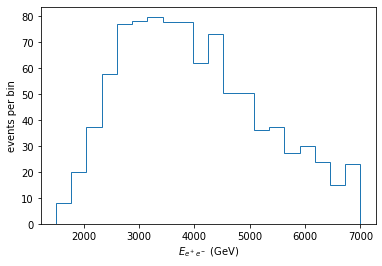

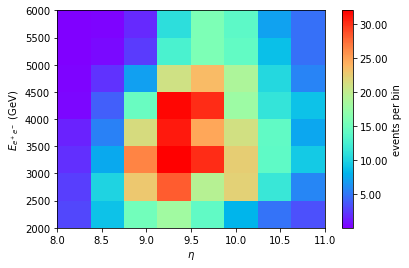

In [5]:
%%time

truth_data = {} #dictionary for storing truth data

truth_data['E'], Ebins, (fig,ax) = get_hist(     #get binnned data for truth point
    sample = sample,
    measurement = 'E', #options: 'E', 'eta', 'm', 'eta+E', 'm+E' (see parameter_estimation.py for measurement assumptions)
    bins = np.linspace(1500,7000,20+1), #bins to be used by np.histogram
    weighted=True, #if True, counts are expected events per bin, if False counts are monte-carlo samples per bin
    plot=True
)


truth_data['eta+E'], eta_E_bins, (fig,ax) = get_hist(
    sample = sample, 
    measurement = 'eta+E', #options: 'E', 'eta', 'm', 'eta+E', 'm+E' (see parameter_estimation.py for measurement assumptions)
    bins = [np.linspace(8,11,8+1),np.linspace(2000,6000,8+1)], #bins to be used by np.histogram
    weighted=True, #if True, counts are expected events per bin, if False counts are monte-carlo samples per bin
    plot=True
)

if True: np.save(f'DarkPhoton-Truth',np.array([truth_data],dtype='object'))

### Define Test Model and Parameter Scan

In [6]:
nevent = int(1e5)     #number of event samples for test points

nexp = 200            #number of pseudo-experiments to generate

llp = 'DarkPhoton'    #llp model ('DarkPhoton' or 'U(1)B-L')

#mass and couplings for parameter scan
masses, couplings = np.unique(np.append(np.linspace(.045,0.055,20),mass)),  np.unique(np.append(np.linspace(2.5e-5, 3.5e-5,10),coupling)) 

foresee = init_llp(energy=energy,llp =llp)

foresee.set_detector(distance=distance, selection=selection, length=length, luminosity=luminosity, channels=channels)

### Parameter Scan (Data Generation and Binning)

In [7]:
%%time

for m in masses: foresee.get_llp_spectrum(mass=m, coupling=1, do_plot=False) 

scan = np.empty((len(masses),len(couplings)),dtype='object') #Load with np.load(f'scan.npy',allow_pickle=True) alternatively


#scan over mass and couplings
for im,m in enumerate(tqdm(masses)):
        
    for ieps,eps in enumerate(couplings):

        test_data = {}
        
        _, _, _, _, weights = foresee.get_events(
            mass=m, 
            energy=energy, 
            couplings = [eps], 
            nsample=1, modes=None
        )
        
        if sum(weights[0].T[0]) != 0.0:
        
            _, weights, sample = foresee.write_events(     #get samples of llp events
                mass = m, 
                coupling = eps, 
                energy = energy,
                nsample = 10,
                numberevent = nevent, 
                return_data = True,
            )

        test_data['E'], _ = get_hist( #get binnned data for truth point
            sample = sample,
            measurement = 'E',
            bins = Ebins,
        )

        test_data['eta+E'], _ = get_hist(
            sample = sample,
            measurement = 'eta+E',
            bins = eta_E_bins,
        )

        scan[im,ieps] = test_data 

np.save(f'scan-DarkPhoton',scan)

save data to file: ../DarkPhoton/model/LLP_spectra/14TeV_111_EPOSLHC_m_0.045.npy
save data to file: ../DarkPhoton/model/LLP_spectra/14TeV_221_EPOSLHC_m_0.045.npy
save data to file: ../DarkPhoton/model/LLP_spectra/14TeV_113_EPOSLHC_m_0.045.npy
save data to file: ../DarkPhoton/model/LLP_spectra/14TeV_Brem_p.pt<1_m_0.045.npy
save data to file: ../DarkPhoton/model/LLP_spectra/14TeV_111_EPOSLHC_m_0.045526315789473686.npy
save data to file: ../DarkPhoton/model/LLP_spectra/14TeV_221_EPOSLHC_m_0.045526315789473686.npy
save data to file: ../DarkPhoton/model/LLP_spectra/14TeV_113_EPOSLHC_m_0.045526315789473686.npy
save data to file: ../DarkPhoton/model/LLP_spectra/14TeV_Brem_p.pt<1_m_0.045526315789473686.npy
save data to file: ../DarkPhoton/model/LLP_spectra/14TeV_111_EPOSLHC_m_0.046052631578947366.npy
save data to file: ../DarkPhoton/model/LLP_spectra/14TeV_221_EPOSLHC_m_0.046052631578947366.npy
save data to file: ../DarkPhoton/model/LLP_spectra/14TeV_113_EPOSLHC_m_0.046052631578947366.npy
save

100%|████████████████████████████████████████| 21/21 [1:34:43<00:00, 270.66s/it]

CPU times: user 1h 33min 3s, sys: 55.7 s, total: 1h 33min 59s
Wall time: 1h 35min 29s


100%|███████████████████████████████████████████| 21/21 [00:06<00:00,  3.13it/s]



Best fit chi2: m = 50.00 eps = 3.00e-05:		24

 1 sigma: 27.3
 2 sigma: 37.7
 3 sigma: 47.7




100%|████████████████████████████████████████| 21/21 [00:00<00:00, 18586.28it/s]

m = 45.00 eps = 2.50e-05:		5908
m = 45.00 eps = 2.61e-05:		4508
m = 45.00 eps = 2.72e-05:		3306
m = 45.00 eps = 2.83e-05:		2294
m = 45.00 eps = 2.94e-05:		1520
m = 45.00 eps = 3.00e-05:		1191
m = 45.00 eps = 3.06e-05:		908
m = 45.00 eps = 3.17e-05:		461
m = 45.00 eps = 3.28e-05:		181
m = 45.00 eps = 3.39e-05:		39
m = 45.00 eps = 3.50e-05:		16
m = 45.53 eps = 2.50e-05:		4444
m = 45.53 eps = 2.61e-05:		3315
m = 45.53 eps = 2.72e-05:		2332
m = 45.53 eps = 2.83e-05:		1510
m = 45.53 eps = 2.94e-05:		921
m = 45.53 eps = 3.00e-05:		677
m = 45.53 eps = 3.06e-05:		483
m = 45.53 eps = 3.17e-05:		191
m = 45.53 eps = 3.28e-05:		45
m = 45.53 eps = 3.39e-05:		8
m = 45.53 eps = 3.50e-05:		81
m = 46.05 eps = 2.50e-05:		5319
m = 46.05 eps = 2.61e-05:		3965
m = 46.05 eps = 2.72e-05:		2794
m = 46.05 eps = 2.83e-05:		1891
m = 46.05 eps = 2.94e-05:		1173
m = 46.05 eps = 3.00e-05:		891
m = 46.05 eps = 3.06e-05:		653
m = 46.05 eps = 3.17e-05:		292
m = 46.05 eps = 3.28e-05:		82
m = 46.05 eps = 3.39e-05:		14
m

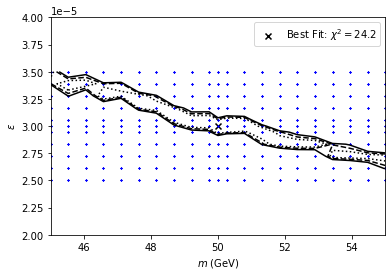

In [8]:
%%time

scan_chi, (fig,ax) = get_chi2( #get chi2 contour and output results
    masses = masses*1e3,
    couplings = couplings,
    scan = scan,
    truth_data = truth_data,
    measurements = ['E'], #options: 'E', 'eta', 'm', 'eta+E', 'm+E' (see parameter_estimation.py for measurement assumptions)
    nexp = nexp,
    printing = True,
    plot=True,
    xlims = (45,55),
    ylims = (2e-5,4e-5)
)

ax.set(yscale='linear')

#plot scan grid
xv, yv = np.meshgrid(masses*1e3,couplings)
ax.scatter(xv,yv,marker='x',color='blue',s=2)

In [9]:
fig.savefig('DarkPhoton.pdf')